In [95]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binance.client import Client
import math

In [96]:
f = open('config.json')
config = json.load(f)

client = Client(config["api_key"], config["secure_key"])
print("Connected to Binance successfully....")

Connected to Binance successfully....


In [97]:
# Set the time period and number of standard deviations for the calculations
time_period = 20
num_std_dev = 2

In [98]:
klines = client.get_historical_klines(config["currency"], Client.KLINE_INTERVAL_5MINUTE, "1 day ago UTC")

klines_dataframe = pd.DataFrame(
    klines, 
    columns=[
        'Open Time', 
        'Open', 
        'High', 
        'Low', 
        'Close', 
        'Volume',
        'Close Time',
        'Quote Asset',
        'Volume',
        'Number of Trades',
        'Taker buy base asset volume',
        'Taker buy quote asset volume'
    ])

In [99]:
display(klines_dataframe)

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset,Volume,Number of Trades,Taker buy base asset volume,Taker buy quote asset volume
0,1670944500000,1335.63000000,1335.90000000,1328.96000000,1330.42000000,2596.80630000,1670944799999,3459507.51526800,3187,1025.64650000,1366251.21315000,0
1,1670944800000,1330.41000000,1332.49000000,1326.38000000,1327.10000000,2567.14410000,1670945099999,3413007.71353300,2856,1214.60210000,1615236.84114100,0
2,1670945100000,1327.22000000,1330.00000000,1326.31000000,1326.67000000,2321.66520000,1670945399999,3082895.94408700,3082,1045.92810000,1389080.94031200,0
3,1670945400000,1326.67000000,1328.14000000,1324.53000000,1325.94000000,3369.66180000,1670945699999,4468452.66150800,3546,1332.33670000,1766631.76350400,0
4,1670945700000,1325.94000000,1329.20000000,1323.36000000,1323.37000000,2742.14900000,1670945999999,3639436.31147200,2803,840.11840000,1114623.17316600,0
...,...,...,...,...,...,...,...,...,...,...,...,...
283,1671029400000,1336.41000000,1342.41000000,1336.41000000,1339.66000000,1957.12690000,1671029699999,2621710.09056000,2486,1112.56970000,1490353.84217100,0
284,1671029700000,1339.66000000,1342.56000000,1339.31000000,1340.73000000,1183.36350000,1671029999999,1586967.22745000,1366,572.89840000,768256.96141400,0
285,1671030000000,1340.84000000,1341.83000000,1338.03000000,1338.50000000,1600.53630000,1671030299999,2144421.65471500,1446,706.11520000,946187.36840900,0
286,1671030300000,1338.52000000,1340.30000000,1338.30000000,1340.15000000,809.27510000,1671030599999,1084060.65935600,828,409.67060000,548821.80441400,0


In [100]:
klines_dataframe.index = np.arange(klines_dataframe.shape[0])

In [101]:
closing_price = klines_dataframe['Close']
close_time = klines_dataframe['Close Time']

In [102]:
# Calculate the rolling mean and standard deviation
rolling_mean = closing_price.rolling(time_period).mean()
rolling_std = closing_price.rolling(time_period).std()

In [103]:
# Calculate the upper and lower bands
upper_band = rolling_mean + num_std_dev * rolling_std
lower_band = rolling_mean - num_std_dev * rolling_std

In [104]:
# Set the scale of the x axis
min_time = close_time.min()
max_time = close_time.max()

# Set the scale of the y axis
min_price = math.floor(float(closing_price.min()))
max_price = math.ceil(float(closing_price.max()))

print(min_time)
print(max_time)

print(min_price)
print(max_price)

1670944799999
1671030899999
1307
1341


In [108]:
display(closing_price)
display(closing_price.min())
display(closing_price.max())

0      1330.42000000
1      1327.10000000
2      1326.67000000
3      1325.94000000
4      1323.37000000
           ...      
283    1339.66000000
284    1340.73000000
285    1338.50000000
286    1340.15000000
287    1339.95000000
Name: Close, Length: 288, dtype: object

'1307.88000000'

'1340.73000000'

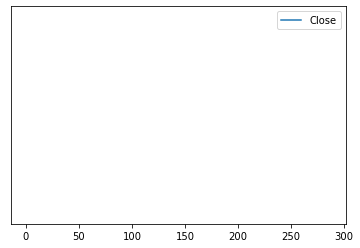

In [116]:
plt.plot(closing_price, label='Close')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(upper_band, label='Upper Band')
plt.plot(lower_band, label='Lower Band')
plt.xlim(min_time, max_time) # In unix time
plt.ylim(1000.00000000, 1400.00000000) # Unsure for price scale
plt.legend()
plt.show()